In [1]:
import os
import sys
project_dir = os.path.dirname(os.getcwd())
sys.path.append(project_dir)

In [2]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


# Data Ingestion

In [3]:
from data.mnist import get_mnist_pipeline

train_loader, val_loader, test_loader = get_mnist_pipeline(batch_size=32)

# Model

In [4]:
import torch
import torch.optim as optim
import models.baseline as mlp
from utils.summary import get_model_stats

teacher = mlp.mnist1200().to(device)
student = mlp.mnist800().to(device)
smaller = mlp.mnist800().to(device)

sample = torch.randn(1, 1, 28, 28).to(device)
with torch.no_grad():
    print("Teacher model stats:")
    pred = teacher(sample)
    for name, param in get_model_stats(teacher, sample.shape).items():
        print(f"{name}: {param}")
    print("Student model stats:")
    pred = smaller(sample)
    for name, param in get_model_stats(student, sample.shape).items():
        print(f"{name}: {param}")

Teacher model stats:
flops: 3832800
params: 3836410
Student model stats:
flops: 1915200
params: 1917610


# Training Loop

In [ ]:
import tqdm
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
import numpy as np
from configs.config import Config
from utils.losses import Accuracy
import itertools


def train_model(train_loader: DataLoader, model: nn.Module, criterion: nn.Module, optimizer: nn.Module,
                scheduler: nn.Module=None, device: str='cpu') -> list:
    """
    Train the model for one epoch.

    Args:
        model: The PyTorch model to train.
        train_loader: DataLoader for the training data.
        optimizer: Optimizer for updating model parameters.
        criterion: Loss function.
        device: Device to run the training on ('cpu' or 'cuda').

    Returns:
        list: Collection of train losses.
    """
    model.train()
    epoch_losses = []
    for inputs, targets in tqdm.tqdm(train_loader, desc='training...', file=sys.stdout):
        inputs = inputs.to(device)
        targets = targets.to(device)
        preds = model(inputs)
        loss = criterion(preds, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
        if scheduler and isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
            scheduler.step(loss.item())
        elif scheduler:
            scheduler.step()
    return epoch_losses


def evaluate_model(val_loader: DataLoader, model: nn.Module, criterion: nn.Module, device: str='cpu') -> list:
    """
    Evaluate the model on validation data.

    Args:
        model: The PyTorch model to evaluate.
        val_loader: DataLoader for the validation data.
        criterion: Loss function.
        device: Device to run the evaluation on ('cpu' or 'cuda').

    Returns:
        list: Collection of metrics.
    """
    model.eval()
    epoch_metrics = []
    with torch.no_grad():
        for inputs, targets in tqdm.tqdm(val_loader, desc='evaluating...', file=sys.stdout):
            inputs = inputs.to(device)
            targets = targets.to(device)
            preds = model(inputs)
            loss = criterion(preds, targets)
            epoch_metrics.append(loss.item())
    return epoch_metrics


def train_val(train_loader, val_loader, model, criterion, optimizer, scheduler, device, aux_metrics, path):
    metrics = {"train_loss": [], "val_loss": []}
    for k in aux_metrics.keys():
        metrics[k] = []
    try:
        best_val_loss = torch.load(path)['accuracy']
    except Exception:
        # best_val_loss = float('inf')
        best_val_loss = 0
    patience = 15
    counter = 0
    epochs = 200

    for epoch in range(epochs):
        train_loss = train_model(train_loader, model, criterion, optimizer, scheduler, device)
        val_loss = evaluate_model(val_loader, model, criterion, device)
        metrics['train_loss'].append(np.mean(train_loss))
        metrics['val_loss'].append(np.mean(val_loss))
        for k, v in aux_metrics.items():
            stat = evaluate_model(val_loader, model, v, device)
            metrics[k].append(np.mean(stat))
        if metrics['accuracy'][-1] >= best_val_loss:
            best_val_loss = metrics['accuracy'][-1]
            counter = 0
            print(f"Epoch {epoch+1}: New best val loss: {best_val_loss:.4f}, Accuracy: {metrics['accuracy'][-1]:.4f} saving model...")
            state = {
                'epoch': epoch,
                'state_dict': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'val_loss': best_val_loss,
                'Accuracy': metrics['accuracy'][-1]
            }
            torch.save(state, path)
        else:
            counter += 1
        if counter >= patience:
            print(f"Epoch {epoch+1}: Early stop triggered.")
            break
    return metrics


def _train_val(cfg: Config):    
    """
    Trains and Validates Model using a Config dataclass
    Args:
    Return:
    """
    try:
        best_val_loss = torch.load(cfg.path)['val_loss']
    except Exception:
        best_val_loss = float('inf')
    patience = 15
    counter = 0
    for epoch in range(cfg.epochs):
        # dump config + add device
        train_loss = train_model(**cfg.train_attr)
        val_loss = evaluate_model(**cfg.val_attr)
        # pop metrics from config
        cfg.metrics['train_loss'].append(np.mean(train_loss))
        cfg.metrics['val_loss'].append(np.mean(val_loss))
        if cfg.metrics['val_loss'][-1] < best_val_loss:
            best_val_loss = cfg.metrics['val_loss'][-1]
            counter = 0
            print(f"Epoch {epoch+1}: New best val loss: {best_val_loss:.4f}, saving model...")
            state = {
                'epoch': epoch,
                'state_dict': cfg.model.state_dict(),
                'optimizer': cfg.optimizer.state_dict(),
                'val_loss': best_val_loss
            }
            torch.save(state, cfg.path)
        else:
            counter += 1
        if counter >= patience:
            print(f"Epoch {epoch+1}: Early stop triggered.")
            break

# Train Teacher

/home/dodogama/anaconda3/envs/stock_ts/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/tmp/ipykernel_146723/4071171176.py:75: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where 

evaluating...: 100%|██████████| 375/375 [00:02<00:00, 143.29it/s]
Epoch 1: New best val loss: 0.7431, Accuracy: 0.74 saving model...
evaluating...: 100%|██████████| 375/375 [00:02<00:00, 134.06it/s]
Epoch 3: New best val loss: 0.7431, Accuracy: 0.74 saving model...
evaluating...: 100%|██████████| 375/375 [00:02<00:00, 151.76it/s]
Epoch 8: New best val loss: 0.7458, Accuracy: 0.75 saving model...
evaluating...: 100%|██████████| 375/375 [00:02<00:00, 127.74it/s]
Epoch 22: New best val loss: 0.7482, Accuracy: 0.75 saving model...
evaluating...: 100%|██████████| 375/375 [00:02<00:00, 136.13it/s]
Epoch 37: Early stop triggered.


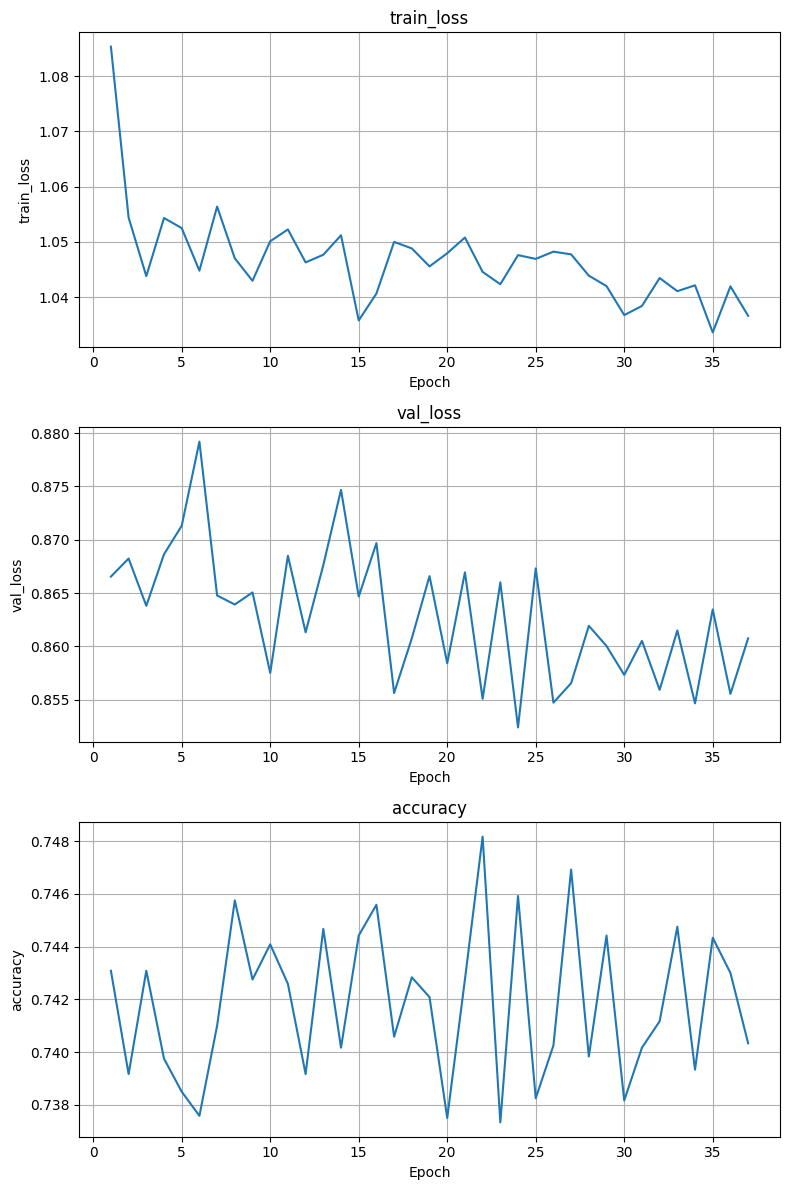

In [7]:
from utils.plots import plot_training_metrics

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(teacher.parameters(), lr=0.005, weight_decay=1e-4)
# optimizer = optim.SGD(teacher.parameters(), lr=0.01, momentum=0.9)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
aux_metrics = {'accuracy': Accuracy()}
path = '../models/weights/teacher.pth'

metrics = train_val(train_loader, val_loader, teacher, criterion, optimizer, scheduler, device, aux_metrics, path)
plot_training_metrics(metrics)

# Train Smaller

/tmp/ipykernel_146723/4071171176.py:75: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_val_loss = torch.load(path)['accuracy']


evaluating...: 100%|██████████| 375/375 [00:02<00:00, 139.28it/s]
Epoch 1: New best val loss: 0.6896, Accuracy: 0.69 saving model...
evaluating...: 100%|██████████| 375/375 [00:02<00:00, 138.79it/s]
Epoch 2: New best val loss: 0.6939, Accuracy: 0.69 saving model...
evaluating...: 100%|██████████| 375/375 [00:02<00:00, 135.49it/s]
Epoch 17: Early stop triggered.


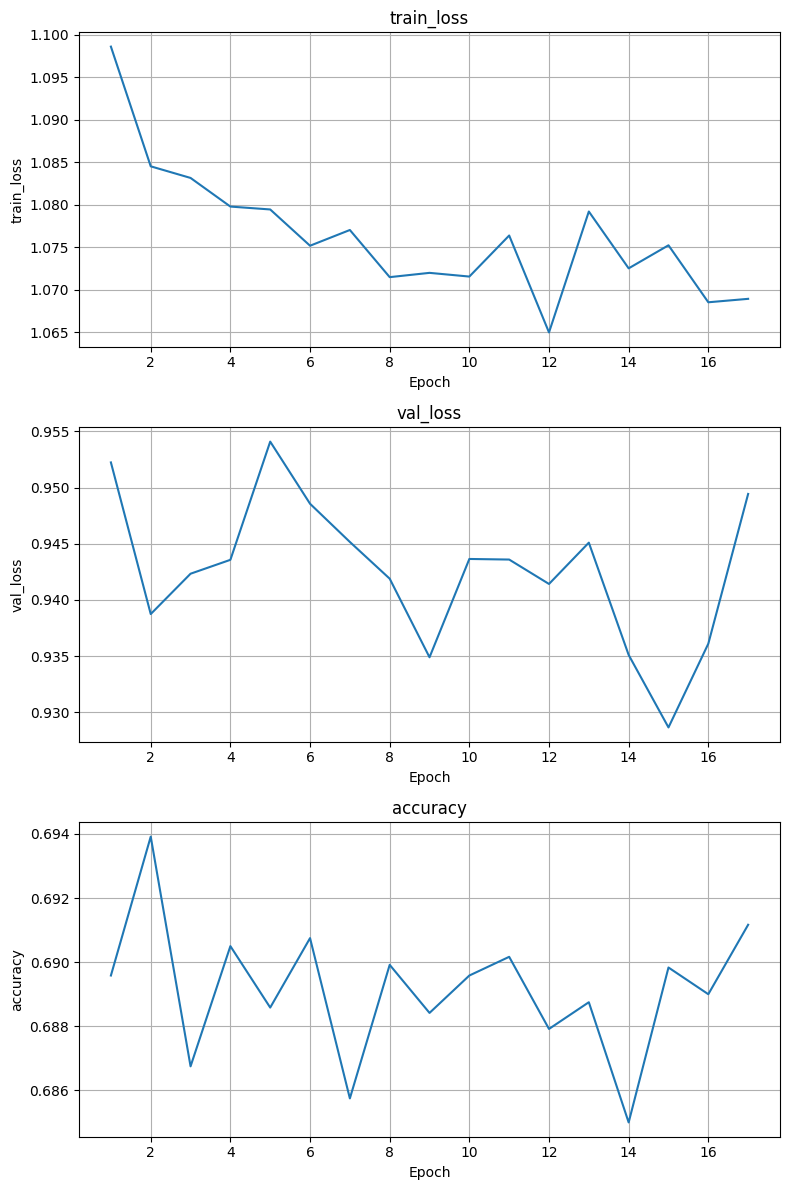

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(smaller.parameters(), lr=0.005)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)
aux_metrics = {'accuracy': Accuracy()}
path = '../models/weights/smaller.pth'

metrics = train_val(train_loader, val_loader, smaller, criterion, optimizer, scheduler, device, aux_metrics, path)
plot_training_metrics(metrics)

# Distill Student

In [ ]:
from utils.losses import DistillationLoss


def distill_model(train_loader: DataLoader, student: nn.Module, teacher: nn.Module, 
                  criterion: nn.Module, optimizer: nn.Module,
                  scheduler: nn.Module=None, device: str='cpu') -> list:
    """
    Train the student model for one epoch using knowledge distillation.

    Args:
        train_loader: DataLoader for the training data.
        student_model: The PyTorch student model to train.
        teacher_model: The PyTorch teacher model (should be in eval mode).
        optimizer: Optimizer for updating student model parameters.
        criterion: Distillation loss function (e.g., DistillationLoss).
        device: Device to run the training on ('cpu' or 'cuda').

    Returns:
        list: Collection of train losses.
    """
    student.train()
    teacher.eval()  # Ensure teacher model is in evaluation mode
    epoch_losses = []
    for inputs, targets in tqdm.tqdm(train_loader, desc='distilling...', file=sys.stdout):
        inputs = inputs.to(device)
        targets = targets.to(device)
        # preds
        student_preds = student(inputs)
        with torch.no_grad():
            teacher_preds = teacher(inputs)
        # distillation loss
        loss = criterion(student_preds, teacher_preds, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
        if scheduler and isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
            scheduler.step(loss.item())
        elif scheduler:
            scheduler.step()
    return epoch_losses


def distill(train_loader, val_loader, student, teacher, loss, criterion, optimizer, scheduler, device, aux_metrics, path):
    metrics = {"train_loss": [], "val_loss": []}
    for k in aux_metrics.keys():
        metrics[k] = []
    try:
        best_val_loss = torch.load(path)['accuracy']
    except Exception:
        best_val_loss = 0 # float('inf')
    patience = 10
    counter = 0
    epochs = 200

    for epoch in range(epochs):
        train_loss = distill_model(train_loader, student, teacher, loss, optimizer, scheduler, device)
        val_loss = evaluate_model(val_loader, student, criterion, device)
        metrics['train_loss'].append(np.mean(train_loss))
        metrics['val_loss'].append(np.mean(val_loss))
        for k, v in aux_metrics.items():
            stat = evaluate_model(val_loader, student, v, device)
            metrics[k].append(np.mean(stat))
        if metrics['accuracy'][-1] >= best_val_loss:
            best_val_loss = metrics['accuracy'][-1]
            counter = 0
            print(f"Epoch {epoch+1}: New best val loss: {metrics['val_loss'][-1]:.4f}, Accuracy: {metrics['accuracy'][-1]:.4f} saving model...")
            state = {
                'epoch': epoch,
                'state_dict': student.state_dict(),
                'optimizer': optimizer.state_dict(),
                'val_loss': metrics['val_loss'][-1],
                'Accuracy': metrics['accuracy'][-1]
            }
            torch.save(state, path)
        else:
            counter += 1
        if counter >= patience:
            print(f"Epoch {epoch+1}: Early stop triggered.")
            break
    return metrics


In [ ]:
import matplotlib.pyplot as plt


teacher.load_state_dict(torch.load('../models/weights/teacher.pth', map_location=device)['state_dict'])
collection = []
Ts = [1, 5, 20, 40]
for T in Ts:
    student = mlp.mnist800().to(device)
    criterion = DistillationLoss(T=T)
    crossentropy = nn.CrossEntropyLoss()
    optimizer = optim.Adam(student.parameters(), lr=0.005)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)
    aux_metrics = {'accuracy': Accuracy()}
    path = f'../models/weights/student{T}.pth'
    metrics = distill(train_loader, val_loader, student, teacher, criterion, crossentropy, optimizer, scheduler, device, aux_metrics, path)
    collection.append(metrics)

# modified
num_metrics = len(metrics)
fig, axes = plt.subplots(num_metrics, 1, figsize=(8, 4 * num_metrics))
if num_metrics == 1:
    axes = [axes]
epochs = range(1, len(next(iter(metrics.values()))) + 1)
for i, k in enumerate(metrics.keys()):
    for j in range(len(collection)):
        axes[i].plot(epochs, collection[j][k], label=Ts[j])
    axes[i].set_title(k)
    axes[i].set_xlabel("Epoch")
    axes[i].set_ylabel(k)
    axes[i].legend()
    axes[i].grid(True)
plt.tight_layout()
plt.show()

/tmp/ipykernel_146723/1562814583.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  teacher.load_state_dict(torch.load('../models/weights/teacher.pth', map_location=device)

evaluating...: 100%|██████████| 375/375 [00:02<00:00, 136.78it/s]
Epoch 1: New best val loss: 0.7222, Accuracy: 0.72 saving model...
evaluating...: 100%|██████████| 375/375 [00:02<00:00, 146.76it/s]
Epoch 3: New best val loss: 0.7238, Accuracy: 0.72 saving model...
evaluating...: 100%|██████████| 375/375 [00:02<00:00, 132.68it/s]
Epoch 4: New best val loss: 0.7254, Accuracy: 0.73 saving model...
evaluating...: 100%|██████████| 375/375 [00:02<00:00, 128.00it/s]
Epoch 6: New best val loss: 0.7271, Accuracy: 0.73 saving model...
evaluating...: 100%|██████████| 375/375 [00:02<00:00, 147.04it/s]
Epoch 13: New best val loss: 0.7319, Accuracy: 0.73 saving model...
evaluating...: 100%|██████████| 375/375 [00:02<00:00, 129.33it/s]
Epoch 28: Early stop triggered.


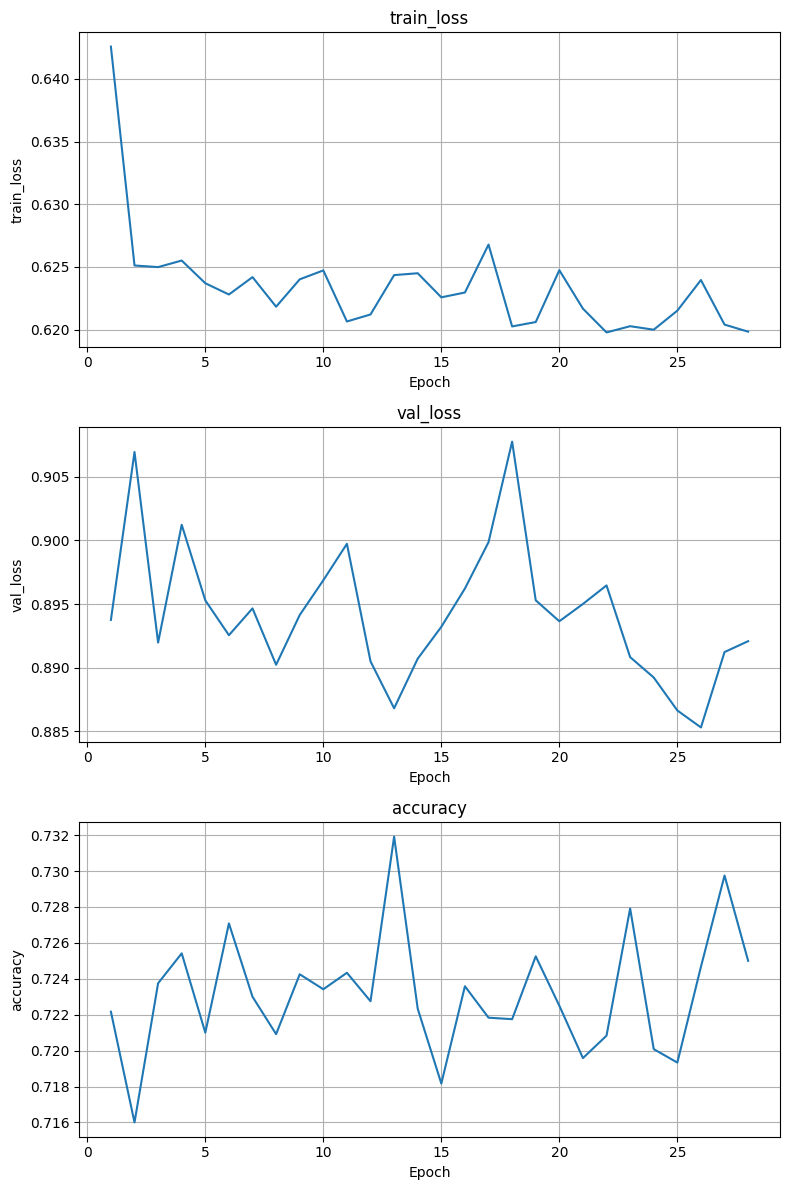

In [14]:
T = 1
student = mlp.mnist800().to(device)
criterion = DistillationLoss(T=T)
crossentropy = nn.CrossEntropyLoss()
optimizer = optim.Adam(student.parameters(), lr=0.005)  # remove regularization
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)
aux_metrics = {'accuracy': Accuracy()}
path = f'../models/weights/student{T}.pth'
teacher.load_state_dict(torch.load('../models/weights/teacher.pth', map_location=device)['state_dict'])

metrics = distill(train_loader, val_loader, student, teacher, criterion, crossentropy, optimizer, scheduler, device, aux_metrics, path)
plot_training_metrics(metrics)

/tmp/ipykernel_146723/3343792500.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  teacher.load_state_dict(torch.load('../models/weights/teacher.pth', map_location=device)

evaluating...: 100%|██████████| 375/375 [00:02<00:00, 129.88it/s]
Epoch 1: New best val loss: 0.7023, Accuracy: 0.70 saving model...
evaluating...: 100%|██████████| 375/375 [00:03<00:00, 118.79it/s]
Epoch 3: New best val loss: 0.7046, Accuracy: 0.70 saving model...
evaluating...: 100%|██████████| 375/375 [00:02<00:00, 134.96it/s]
Epoch 17: New best val loss: 0.7048, Accuracy: 0.70 saving model...
evaluating...: 100%|██████████| 375/375 [00:02<00:00, 132.28it/s]
Epoch 19: New best val loss: 0.7051, Accuracy: 0.71 saving model...
evaluating...: 100%|██████████| 375/375 [00:02<00:00, 137.54it/s]
Epoch 23: New best val loss: 0.7060, Accuracy: 0.71 saving model...
evaluating...: 100%|██████████| 375/375 [00:02<00:00, 132.73it/s]
Epoch 30: New best val loss: 0.7124, Accuracy: 0.71 saving model...
evaluating...: 100%|██████████| 375/375 [00:03<00:00, 113.30it/s]
Epoch 45: Early stop triggered.


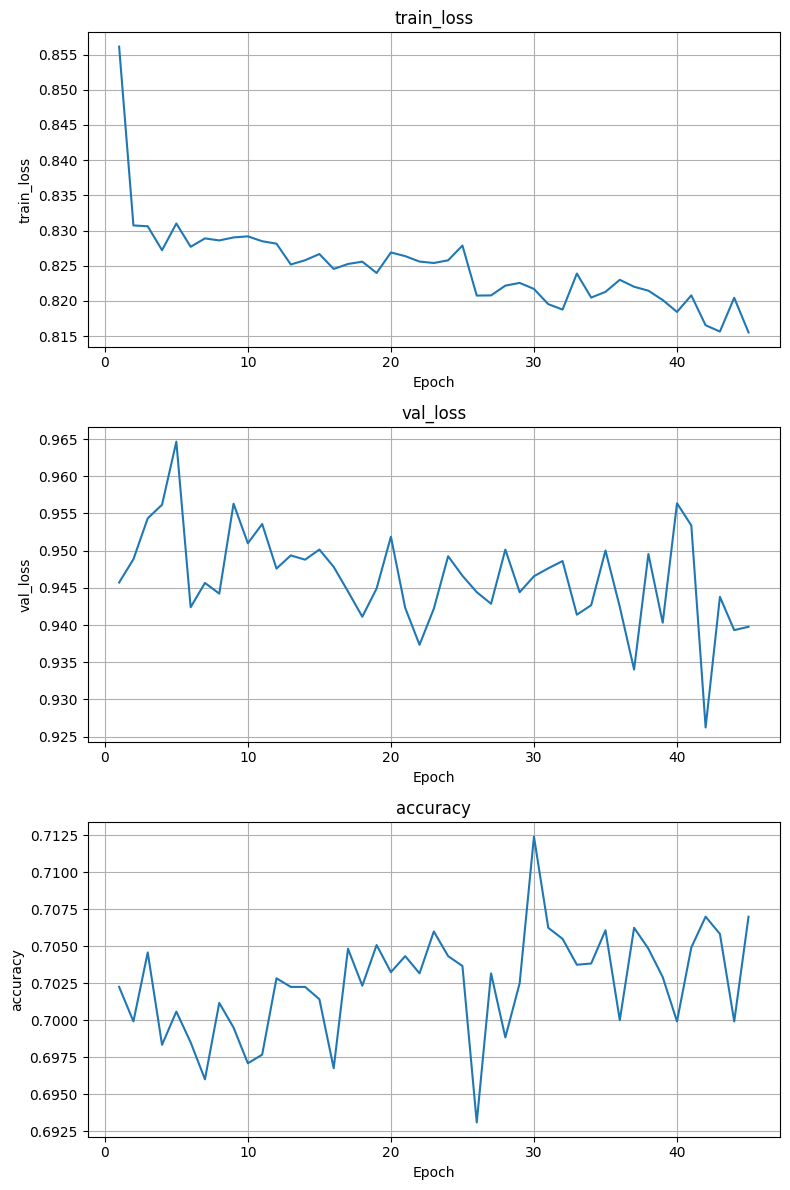

In [15]:
T = 5
student = mlp.mnist800().to(device)
criterion = DistillationLoss(T=T)
crossentropy = nn.CrossEntropyLoss()
optimizer = optim.Adam(student.parameters(), lr=0.005)  # remove regularization
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)
aux_metrics = {'accuracy': Accuracy()}
path = f'../models/weights/student{T}.pth'
teacher.load_state_dict(torch.load('../models/weights/teacher.pth', map_location=device)['state_dict'])

metrics = distill(train_loader, val_loader, student, teacher, criterion, crossentropy, optimizer, scheduler, device, aux_metrics, path)
plot_training_metrics(metrics)

/tmp/ipykernel_146723/4155517535.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  teacher.load_state_dict(torch.load('../models/weights/teacher.pth', map_location=device

evaluating...: 100%|██████████| 375/375 [00:02<00:00, 133.10it/s]
Epoch 1: New best val loss: 0.6933, Accuracy: 0.69 saving model...
evaluating...: 100%|██████████| 375/375 [00:02<00:00, 127.75it/s]
Epoch 7: New best val loss: 0.6937, Accuracy: 0.69 saving model...
evaluating...: 100%|██████████| 375/375 [00:02<00:00, 132.14it/s]
Epoch 18: New best val loss: 0.6981, Accuracy: 0.70 saving model...
evaluating...: 100%|██████████| 375/375 [00:02<00:00, 128.43it/s]
Epoch 33: Early stop triggered.


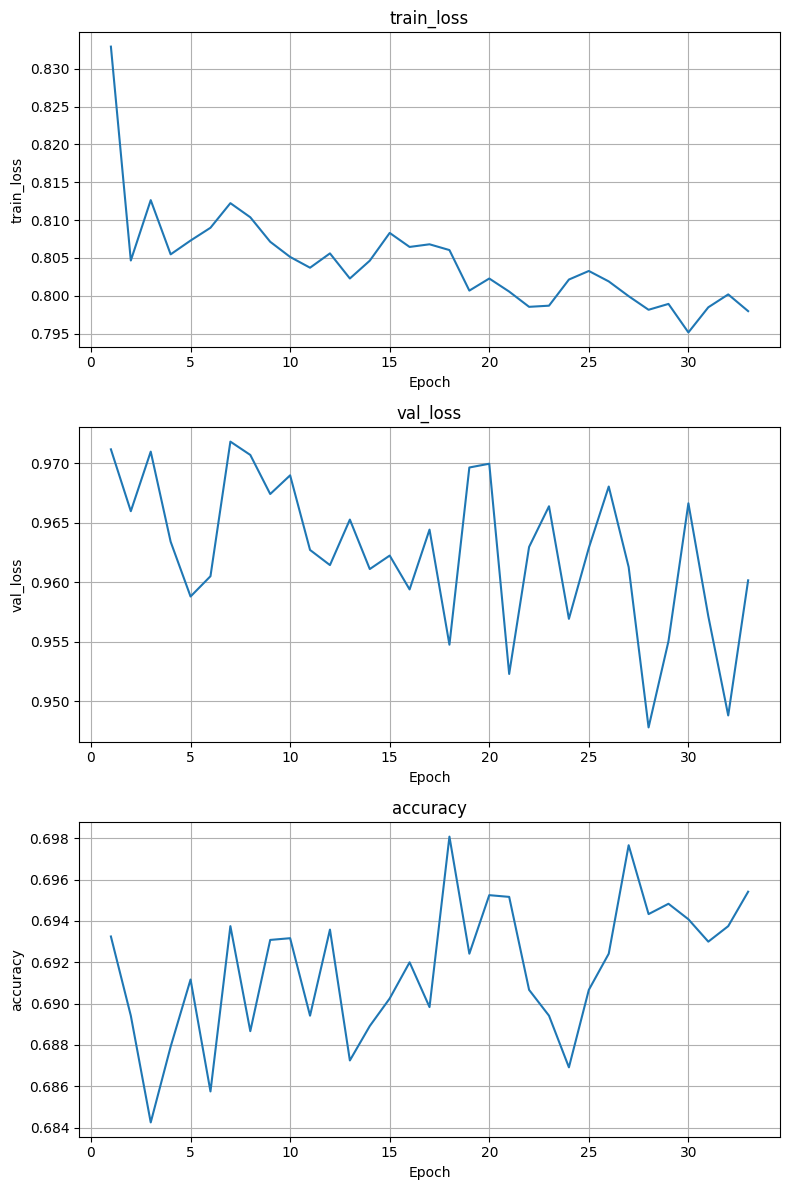

In [ ]:
T = 20
student = mlp.mnist800().to(device)
criterion = DistillationLoss(T=T)
crossentropy = nn.CrossEntropyLoss()
optimizer = optim.Adam(student.parameters(), lr=0.005)
# optimizer = optim.SGD(student.parameters(), lr=0.01, momentum=0.9)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
aux_metrics = {'accuracy': Accuracy()}
path = f'../models/weights/student{T}.pth'
teacher.load_state_dict(torch.load('../models/weights/teacher.pth', map_location=device)['state_dict'])

metrics = distill(train_loader, val_loader, student, teacher, criterion, crossentropy, optimizer, scheduler, device, aux_metrics, path)
plot_training_metrics(metrics)

/tmp/ipykernel_146723/3046784180.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  teacher.load_state_dict(torch.load('../models/weights/teacher.pth', map_location=device)

evaluating...: 100%|██████████| 375/375 [00:03<00:00, 109.71it/s]
Epoch 1: New best val loss: 0.6557, Accuracy: 0.66 saving model...
evaluating...: 100%|██████████| 375/375 [00:03<00:00, 118.35it/s]
Epoch 2: New best val loss: 0.6569, Accuracy: 0.66 saving model...
evaluating...: 100%|██████████| 375/375 [00:02<00:00, 129.54it/s]
Epoch 12: New best val loss: 0.6571, Accuracy: 0.66 saving model...
evaluating...: 100%|██████████| 375/375 [00:02<00:00, 134.38it/s]
Epoch 13: New best val loss: 0.6602, Accuracy: 0.66 saving model...
evaluating...: 100%|██████████| 375/375 [00:02<00:00, 136.59it/s]
Epoch 24: New best val loss: 0.6639, Accuracy: 0.66 saving model...
evaluating...: 100%|██████████| 375/375 [00:02<00:00, 141.42it/s]
Epoch 37: New best val loss: 0.6652, Accuracy: 0.67 saving model...
evaluating...: 100%|██████████| 375/375 [00:02<00:00, 125.15it/s]
Epoch 52: New best val loss: 0.6704, Accuracy: 0.67 saving model...
evaluating...: 100%|██████████| 375/375 [00:02<00:00, 136.36it/s

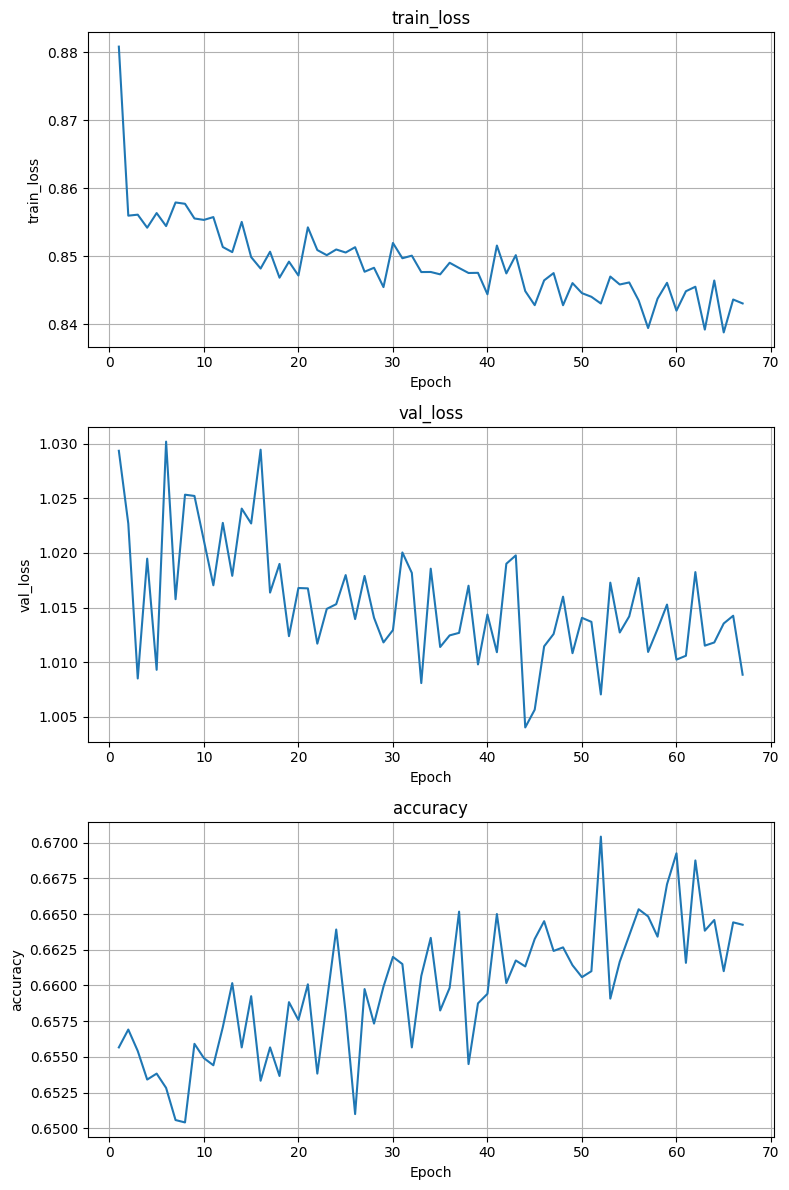

In [17]:
T = 40
student = mlp.mnist800().to(device)
criterion = DistillationLoss(T=T)
crossentropy = nn.CrossEntropyLoss()
optimizer = optim.Adam(student.parameters(), lr=0.005)  # remove regularization
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)
aux_metrics = {'accuracy': Accuracy()}
path = f'../models/weights/student{T}.pth'
teacher.load_state_dict(torch.load('../models/weights/teacher.pth', map_location=device)['state_dict'])

metrics = distill(train_loader, val_loader, student, teacher, criterion, crossentropy, optimizer, scheduler, device, aux_metrics, path)
plot_training_metrics(metrics)

# Compare: Teacher, Smaller, Student

In [18]:
def eval(test_loader, model, device, aux_metrics={}):
    metrics = {}
    for k, m in aux_metrics.items():
        metrics[k] = np.mean(evaluate_model(test_loader, model, m, device))
    return metrics        

In [19]:
teacher_state = torch.load('../models/weights/teacher.pth', map_location=device)
student_state = torch.load('../models/weights/student5.pth', map_location=device)
smaller_state = torch.load('../models/weights/smaller.pth', map_location=device)
aux_metrics = {'crossentropy': nn.CrossEntropyLoss(), 'accuracy': Accuracy()}

teacher.load_state_dict(teacher_state['state_dict'])
student.load_state_dict(student_state['state_dict'])
smaller.load_state_dict(smaller_state['state_dict'])

# work on test sets
teacher_metrics = eval(test_loader, teacher, device, aux_metrics)
student_metrics = eval(test_loader, student, device, aux_metrics)
smaller_metrics = eval(test_loader, smaller, device, aux_metrics)

# look at the best val_losses
print(f"Teacher: Val loss: {teacher_state['val_loss']:.4f}, Accuracy: {teacher_state['Accuracy']:.4f}")
print(f"Student: Val loss: {student_state['val_loss']:.4f}, Accuracy: {student_state['Accuracy']:.4f}")
print(f"Smaller: Val loss: {smaller_state['val_loss']:.4f}, Accuracy: {smaller_state['Accuracy']:.4f}")
print("Test results:")
for k in aux_metrics.keys():
    print(f"""{k}: 
          Teacher = {teacher_metrics[k]:.4f}, 
          Student = {student_metrics[k]:.4f}, 
          Smaller = {smaller_metrics[k]:.4f}""")

/tmp/ipykernel_146723/939686449.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  teacher_state = torch.load('../models/weights/teacher.pth', map_location=device)
/tmp/ipy

evaluating...: 100%|██████████| 313/313 [00:02<00:00, 142.08it/s]
Teacher: Val loss: 0.7482, Accuracy: 0.7482
Student: Val loss: 0.7124, Accuracy: 0.7124
Smaller: Val loss: 0.6939, Accuracy: 0.6939
Test results:
crossentropy: 
          Teacher = 0.8330, 
          Student = 0.9337, 
          Smaller = 0.9376
accuracy: 
          Teacher = 0.7564, 
          Student = 0.7041, 
          Smaller = 0.6854


# Transfer Set Training

/home/dodogama/anaconda3/envs/stock_ts/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/tmp/ipykernel_146723/1003941234.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where 

evaluating...: 100%|██████████| 375/375 [00:02<00:00, 137.85it/s]
Epoch 1: New best val loss: 0.6416, Accuracy: 0.64 saving model...
evaluating...: 100%|██████████| 375/375 [00:02<00:00, 143.28it/s]
Epoch 2: New best val loss: 0.6419, Accuracy: 0.64 saving model...
evaluating...: 100%|██████████| 375/375 [00:02<00:00, 134.07it/s]
Epoch 3: New best val loss: 0.6450, Accuracy: 0.65 saving model...
evaluating...: 100%|██████████| 375/375 [00:02<00:00, 140.53it/s]
Epoch 4: New best val loss: 0.6465, Accuracy: 0.65 saving model...
evaluating...: 100%|██████████| 375/375 [00:02<00:00, 143.69it/s]
Epoch 6: New best val loss: 0.6492, Accuracy: 0.65 saving model...
evaluating...: 100%|██████████| 375/375 [00:02<00:00, 126.27it/s]
Epoch 21: Early stop triggered.


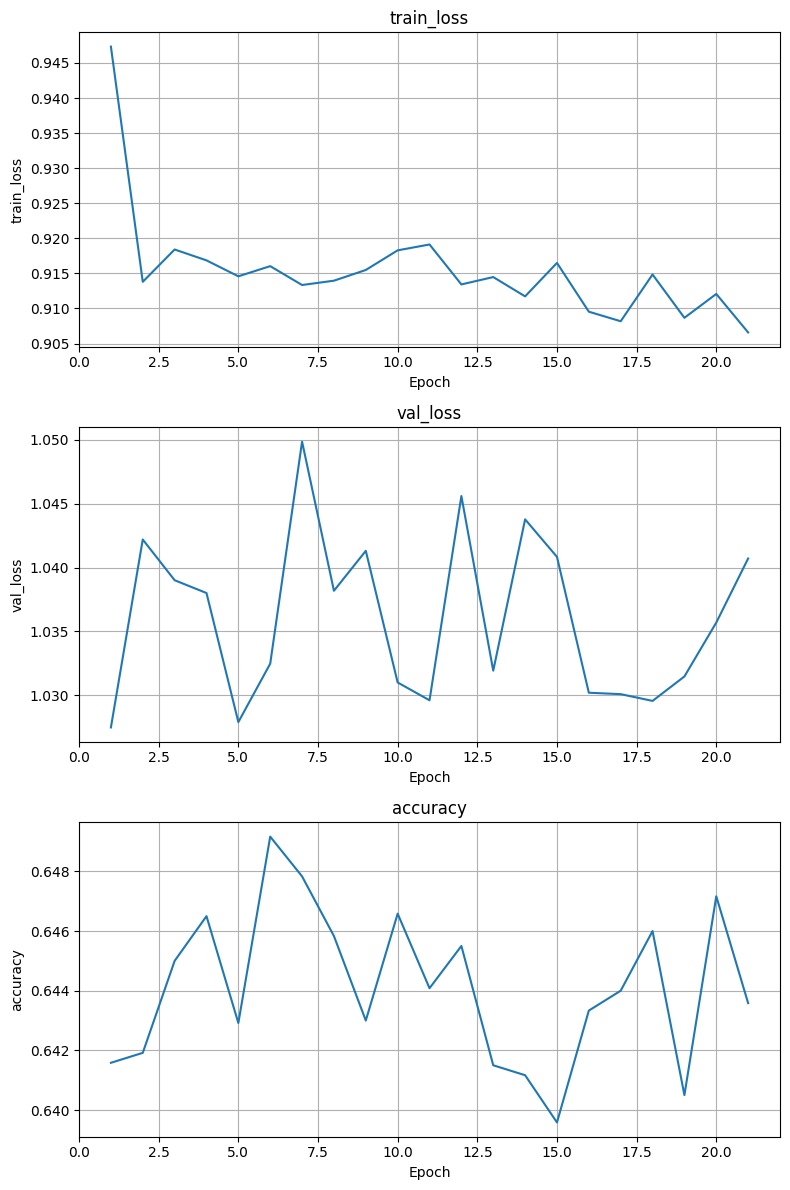

In [20]:
# transfer set
train_loader, val_loader, test_loader = get_mnist_pipeline(batch_size=32, exclude={0})
student = mlp.mnist800().to(device)

T = 5
criterion = DistillationLoss(T=T)
crossentropy = nn.CrossEntropyLoss()
optimizer = optim.Adam(student.parameters(), lr=0.005)  # remove regularization
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)
aux_metrics = {'accuracy': Accuracy()}
path = f'../models/weights/student{T}_0.pth'
teacher.load_state_dict(torch.load('../models/weights/teacher.pth', map_location=device)['state_dict'])

metrics = distill(train_loader, val_loader, student, teacher, criterion, crossentropy, optimizer, scheduler, device, aux_metrics, path)
plot_training_metrics(metrics)

In [21]:
smaller_state = torch.load('../models/weights/smaller.pth', map_location=device)
student_state = torch.load(path, map_location=device)
aux_metrics = {'crossentropy': nn.CrossEntropyLoss(), 'accuracy': Accuracy()}

smaller.load_state_dict(smaller_state['state_dict'])
student.load_state_dict(student_state['state_dict'])

# work on test sets
smaller_metrics = eval(test_loader, smaller, device, aux_metrics)
student_metrics = eval(test_loader, student, device, aux_metrics)

# look at the best val_losses
print(f"Teacher: Val loss: {smaller_state['val_loss']:.4f}, Accuracy: {smaller_state['Accuracy']:.4f}")
print(f"Student: Val loss: {student_state['val_loss']:.4f}, Accuracy: {student_state['Accuracy']:.4f}")
print("Test results:")
for k in aux_metrics.keys():
    print(f"""{k}: 
          Smaller = {smaller_metrics[k]:.4f}
          Student = {student_metrics[k]:.4f}""")

/tmp/ipykernel_146723/1089755654.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  smaller_state = torch.load('../models/weights/smaller.pth', map_location=device)
/tmp/ip

evaluating...: 100%|██████████| 313/313 [00:02<00:00, 118.53it/s]
Teacher: Val loss: 0.6939, Accuracy: 0.6939
Student: Val loss: 0.6492, Accuracy: 0.6492
Test results:
crossentropy: 
          Smaller = 0.9359
          Student = 1.0032
accuracy: 
          Smaller = 0.6883
          Student = 0.6527
